## Загрузка библиотек

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error

## Загрузка и предобработка данных

In [2]:
import kagglehub
import os

path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")
file_path = os.path.join(path, 'household_power_consumption.txt')
df = pd.read_csv(file_path, sep=";", parse_dates={"Datetime": ["Date", "Time"]}, infer_datetime_format=True, na_values="?")
df.head()

<ipython-input-2-198a75833d4c>:6: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  df = pd.read_csv(file_path, sep=";", parse_dates={"Datetime": ["Date", "Time"]}, infer_datetime_format=True, na_values="?")
<ipython-input-2-198a75833d4c>:6: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df = pd.read_csv(file_path, sep=";", parse_dates={"Datetime": ["Date", "Time"]}, infer_datetime_format=True, na_values="?")
<ipython-input-2-198a75833d4c>:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df = pd.read_csv(file_path, sep=";", parse_dat

,Datetime,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [3]:
# Приводим столбцы к числовому виду
numeric_columns = [
    "Global_active_power", "Global_reactive_power", "Voltage",
    "Global_intensity", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"
]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors="coerce")
df = df.dropna()
df = df.resample("h", on="Datetime").mean().reset_index()
df = df.interpolate(method="linear")

# Добавляем временные признаки
df["hour"] = df["Datetime"].dt.hour
df["dayofweek"] = df["Datetime"].dt.dayofweek
df["month"] = df["Datetime"].dt.month
df["year"] = df["Datetime"].dt.year
df["day"] = df["Datetime"].dt.day
df["day_of_year"] = df["Datetime"].dt.dayofyear
df = df.set_index("Datetime")

df = df.dropna()
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,month,year,day,day_of_year
Datetime,,,,,,,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111,17,5,12,2006,16,350
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667,18,5,12,2006,16,350
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333,19,5,12,2006,16,350
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333,20,5,12,2006,16,350
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667,21,5,12,2006,16,350


In [4]:
target_col = "Global_active_power"
for lag in [1, 2, 3, 6, 24]:  # Часовые лаги
    df[f'lag_{lag}'] = df[target_col].shift(lag)
df.dropna(inplace=True)


feature_cols = ["Sub_metering_1", "Sub_metering_2", "Sub_metering_3",
                "hour", "dayofweek", "month", "year", "day", "day_of_year",
                "lag_1", "lag_2", "lag_3", "lag_6", "lag_24"]


train, test = train_test_split(df, train_size=0.8, shuffle=False)
X_train, y_train = train[feature_cols], train[target_col]
X_test, y_test = test[feature_cols], test[target_col]

In [5]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,dayofweek,month,year,day,day_of_year,lag_1,lag_2,lag_3,lag_6,lag_24
Datetime,,,,,,,,,,,,,,,,,,
2006-12-17 17:00:00,3.406767,0.166633,234.229833,14.510000,0.0,0.466667,16.816667,17,6,12,2006,17,351,3.326033,2.985400,2.092633,2.471000,4.222889
2006-12-17 18:00:00,3.697100,0.135067,234.372333,15.750000,0.0,0.000000,16.833333,18,6,12,2006,17,351,3.406767,3.326033,2.985400,1.915867,3.632200
2006-12-17 19:00:00,2.908400,0.265167,233.195667,12.516667,0.0,0.516667,16.683333,19,6,12,2006,17,351,3.697100,3.406767,3.326033,1.660767,3.400233
2006-12-17 20:00:00,3.361500,0.271500,236.426500,14.276667,0.0,1.116667,17.116667,20,6,12,2006,17,351,2.908400,3.697100,3.406767,2.092633,3.268567
2006-12-17 21:00:00,3.040767,0.267967,239.104167,12.716667,0.0,1.200000,17.500000,21,6,12,2006,17,351,3.361500,2.908400,3.697100,2.985400,3.056467


## Поиск лучших гиперпараметров для модели

In [6]:
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1]
}

In [8]:
from xgboost import XGBRegressor

model = XGBRegressor(random_state=42, enable_categorical=True)
grid_search = GridSearchCV(model, param_grid, scoring="neg_mean_absolute_error", cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
print(f"Лучшие параметры: {grid_search.best_params_}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Лучшие параметры: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [9]:
X_test_48 = X_test.iloc[-48:]  # Берем последние 48 точек
y_test_48 = y_test.iloc[-48:]
predictions = best_model.predict(X_test_48)

## Функция подсчета и вывода метрик, визуализации

In [12]:
def metrics_plot(y_test, predictions):
  mse = mean_squared_error(y_test, predictions)
  mae = mean_absolute_error(y_test, predictions)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_test, predictions)
  mape = mean_absolute_percentage_error(y_test, predictions)
  print(f"\nМетрики:")
  print(f"MSE: {mse:.3f}")
  print(f"MAE: {mae:.3f}")
  print(f"RMSE: {rmse:.3f}")
  print(f"R²: {r2:.3f}")
  print(f"MAPE: {mape:.3f}")

  plt.figure(figsize=(12,6))
  plt.plot(y_test.index, y_test, label="Факт", color='blue')
  plt.plot(y_test.index, predictions, label="Прогноз", linestyle="dashed", color='orange')
  plt.legend()
  plt.xlabel("Дата")
  plt.ylabel("Global Active Power (kW)")
  plt.title("Прогноз (XGBoost):Global Active Power")
  plt.show()


Метрики:
MSE: 0.045
MAE: 0.150
RMSE: 0.213
R²: 0.905
MAPE: 0.165


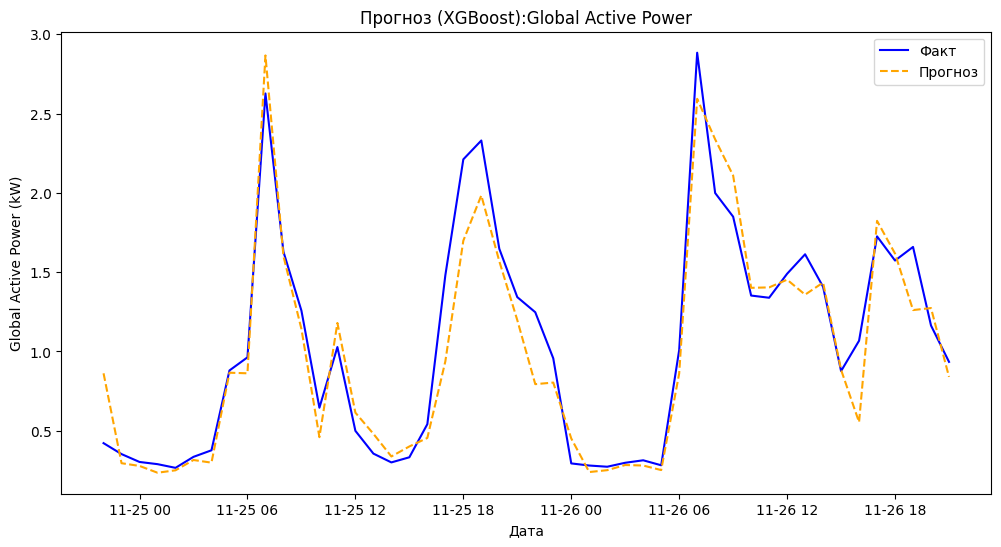

In [13]:
metrics_plot(y_test_48, predictions)


Метрики:
MSE: 0.052
MAE: 0.156
RMSE: 0.229
R²: 0.918
MAPE: 0.169


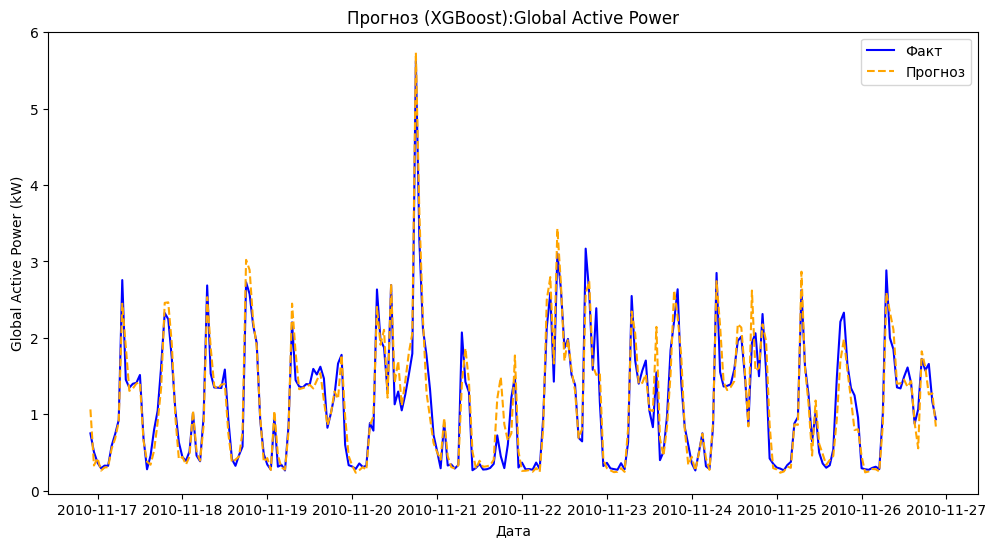

In [14]:
X_test_10 = X_test.iloc[-240:]  # Берем последние 10 дней (240 точек)
y_test_10 = y_test.iloc[-240:]
predictions10 = best_model.predict(X_test_10)

metrics_plot(y_test_10, predictions10)


Метрики:
MSE: 0.083
MAE: 0.196
RMSE: 0.288
R²: 0.879
MAPE: 0.195


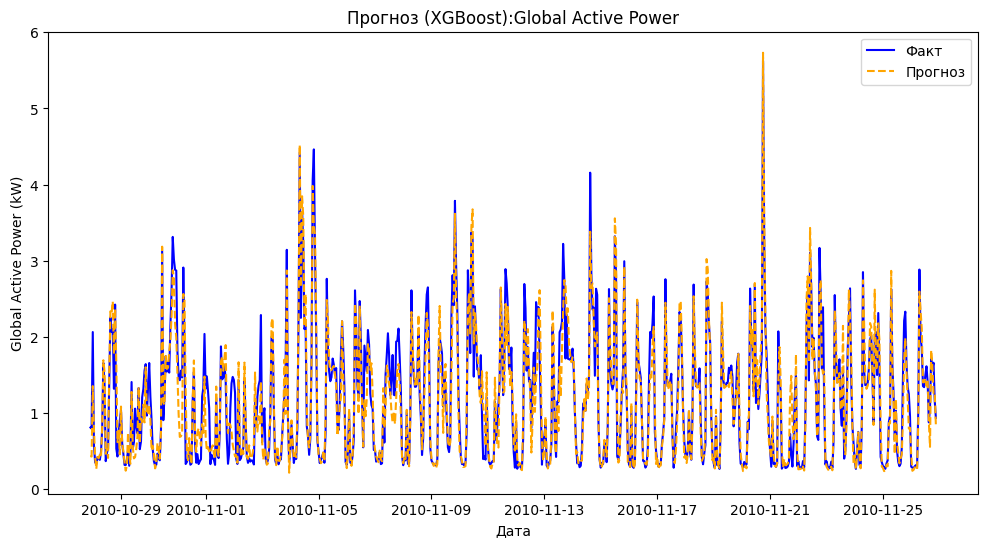

In [15]:
X_test_30 = X_test.iloc[-720:]  # Берем последние 30 дней
y_test_30 = y_test.iloc[-720:]
predictions30 = best_model.predict(X_test_30)

metrics_plot(y_test_30, predictions30)

Видно, как MSE понемногу растет с большим горизонтом прогнозирования.